# Visualisation & High-dimensionality Data

**Intro** [Start](0.0_StartHere.ipynb) • [Intro](1.1_Introduction.ipynb)
<br> **pyrolite** [Geochem](2.1_pyroliteGeochem.ipynb) • [Visualisation](2.2_pyroliteVis.ipynb) • [alphaMELTS](2.3_pyroliteMELTS.ipynb) • [lambdas](2.4_lambdas.ipynb) <br>   **Machine Learning** [Intro](4.0_MachineLearning.ipynb) • [Features](4.1_Features.ipynb)• <mark>[High-D Vis](4.3_HighDVis.ipynb)</mark> • [Classification](4.4_Classification.ipynb) <br>  **GitHub** [geochem4nickel](https://github.com/morganjwilliams/geochem4nickel) • [pyrolite](https://github.com/morganjwilliams/pyrolite)

#### <i class="fa fa-twitter" aria-hidden="true"><a href="https://twitter.com/metasomite" style="font-family:Courier New,Courier,Lucida Sans Typewriter,Lucida Typewriter,monospace;"> @metasomite</a></i>

Visualisation of data which has high dimensionality is challenging, and one solution is to provide visualisations in low-dimension representations of the space actually spanned by the data. Here we provide an example of visualisation of classification predictions and relative prediction certainty for a dataset from [Ueki2018] (using entropy across predicted probability for each individual class, [adapted from pyrolite documentation](https://pyrolite.readthedocs.io/en/develop/usage/eg/plotting/manifold.html)).

[Ueki2018]: https://doi.org/10.1029/2017GC007401 "Ueki, K., Hino, H., Kuwatani, T., 2018. Geochemical Discrimination and Characteristics of Magmatic Tectonic Settings: A Machine-Learning-Based Approach. Geochemistry, Geophysics, Geosystems 19, 1327–1347."

We'll import some standard packages, build a classifer and try to construct a visualiation combining both an approximation of the high-dimensional spatial relationships (those being utilised by the classifier) in addition to information about the probability uncertainty (where more faded colors indicate less certain classifications).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from pyrolite.util.skl.pipeline import SVC_pipeline
from pyrolite.util.skl.vis import plot_mapping
from pyrolite.util.plot import __DEFAULT_DISC_COLORMAP__

Using TensorFlow backend.


In [2]:
from pyrolite.util.skl.transform import CLRTransform
df = pd.read_csv('https://storage.googleapis.com/aegc2019/ueki2018.csv')
classes = {c: ix for ix, c in enumerate(df.Class.unique())}
X, y = CLRTransform().transform(df.loc[:, [i for i in df.columns if i != "Class"]]), df["Class"]
y = y.apply(lambda x: classes[x]) # turn these into integers for the colormap

In [3]:
svc = SVC_pipeline(probability=True, scaler=StandardScaler(), kernel='rbf')
gs = svc.fit(X, y)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of  10 | elapsed:    8.6s remaining:    8.6s
[Parallel(n_jobs=4)]: Done   7 out of  10 | elapsed:    8.8s remaining:    3.7s
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:   10.2s finished


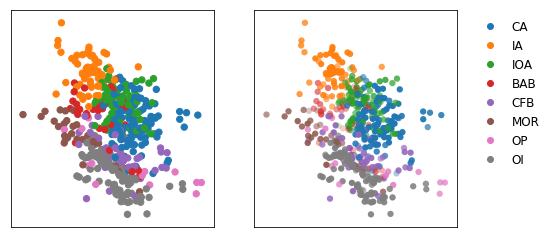

In [ ]:
from pyrolite.util.plot import proxy_line

fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(8, 4))

xsample = X.sample(500)
s=40

a, tfm, mapped = plot_mapping(
    xsample, 
    gs.best_estimator_, 
    ax=ax[1], 
    s=s,
    init="pca"
)
ax[0].scatter(*mapped.T, c=__DEFAULT_DISC_COLORMAP__(gs.predict(xsample)), s=s)

ax[0].set_xticks([])
ax[0].set_yticks([])

ax[1].legend([proxy_line(c=__DEFAULT_DISC_COLORMAP__(ix), ls='none', marker='o') for c, ix in classes.items()], 
             [c for c in classes.keys()], 
             bbox_to_anchor=(1.05, 1.0), 
             loc='upper left', 
             frameon=False, 
             fontsize=12);

### UMAP

Uniform Manifold Approximation and Projection (UMAP) is a dimension reduction technique which can be used in a very similar way to other manifold methods within scikit-learn ([McInnes2018]), with the added flexibility of being able transform new/novel data. This is particulary useful for visualising training and testing data together, but can also be applied to map reference compositions and boundaries into the projected space. UMAP can also be used for semi-supervised and supervised dimensional reduction and metric learning, but this is beyond the scope of these notebooks.

The technique is based on a specific set of assumptions which may be violated in practise, but it remains effective for the uses described here.


[McInnes2018]:  https://doi.org/10.21105/joss.00861 "McInnes, L., Healy, J., Saul, N., Grossberger, L., 2018. UMAP: uniform manifold approximation and projection. The Journal of Open Source Software 3, 861."

In [ ]:
import umap.umap_ as umap  # required in case of umap install errors

reducer = umap.UMAP(metric='mahalanobis', min_dist=0.1, n_neighbors=30)
embedding = reducer.fit_transform(X)

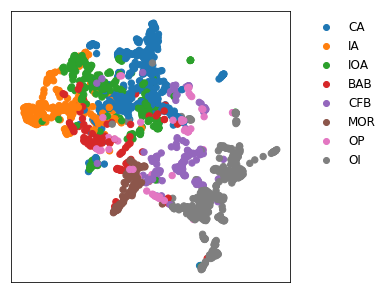

In [ ]:
fig, ax = plt.subplots(1, figsize=(5,5))
ax.scatter(*embedding.T, 
           c=__DEFAULT_DISC_COLORMAP__(gs.predict(X)),
           s=s)
ax.set_xticks([])
ax.set_yticks([])
ax.legend([proxy_line(c=__DEFAULT_DISC_COLORMAP__(ix), ls='none', marker='o') for c, ix in classes.items()], 
          [c for c in classes.keys()],
          bbox_to_anchor=(1.05, 1.0), 
          loc='upper left', 
          frameon=False, 
          fontsize=12);

You can also change the number of components, for example to generate 3D figures:

In [ ]:
threeDreducer = umap.UMAP(n_components=3, metric='mahalanobis', n_neighbors=50)
threeDembedding = threeDreducer.fit_transform(X)

In [ ]:
from pyrolite.util.skl import alphas_from_multiclass_prob

c = __DEFAULT_DISC_COLORMAP__(gs.predict(X)) # predicted classes
ps = gs.predict_proba(X) # probabilities
c[:, -1] = alphas_from_multiclass_prob(ps, alpha=0.95) # append alphas to RGBA colours

In [ ]:
import ipyvolume as ipv
ipv.figure()
ipv.quickscatter(*threeDembedding.T,
                 color=c,
                 size=2, 
                 marker='sphere')

Next: [Classification](4.4_Classification.ipynb)